## load libraries

In [1]:
import warnings
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import os 
from mpl_toolkits.axes_grid1 import make_axes_locatable

import numpy as np
import numpy.ma as ma
from scipy import stats
import scipy.spatial.distance as sp_distance
from sklearn.svm import NuSVC
from sklearn import preprocessing
import seaborn as sns 
import pandas as pd
import matplotlib.pyplot as plt
from pandas import *
from scipy.stats import zscore, norm
from sklearn import linear_model
#from isc_reorder import isc_reorder
#from isc_recall import isc_recall
import pickle

from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
import statsmodels.api as sm
import statsmodels.formula.api as smf

%autosave 5
%matplotlib inline

Autosaving every 5 seconds


## set variables

In [2]:
data_dir = '/Users/barnettlab/Documents/cartoon_recall/fmri_data/'
analysis_dir = '/Users/barnettlab/Documents/cartoon_recall/fmri_data/'
roi_list = pd.read_excel(analysis_dir+'roilist.xlsx')
movie_list = ['barmaid','bluestreets']
subjlist_full = pd.read_excel(analysis_dir+'subjlist.xlsx')
hc_list = ['_L_ant_hippo.nii.gz','_L_post_hippo.nii.gz','_R_ant_hippo.nii.gz','_R_post_hippo.nii.gz']
event_boundaries = pd.read_excel(analysis_dir+'fmri_recall_event_boundaries_14events_each.xlsx')

## import node names
glasser_nodes=pd.read_excel('hc_glasser_nodes.xlsx')
recall_scoring = pd.read_excel(analysis_dir+'event detail scoring 14 events.xlsx')

num_subs = 24

In [3]:
# load in univariate activity

boundary_diff_hc = np.load('boundary_diff.npy')
boundary_diff_pmn = np.load('boundary_diff_pmn.npy')
boundary_diff_mtn = np.load('boundary_diff_mtn.npy')
boundary_diff_atn = np.load('boundary_diff_atn.npy')
boundary_diff_mpn = np.load('boundary_diff_mpn.npy')

In [4]:
indsort_sub = np.loadtxt(analysis_dir+'indsort_subnetworks.txt')
indsort_sub=indsort_sub.astype('int32')
for i in range(len(indsort_sub)):
    indsort_sub[i] = indsort_sub[i] -1

indsort_sub =np.append(indsort_sub,[358,359,360,361])

In [5]:
## make array of subject ids
subject_list = subjlist_full['subj_id'].unique()
## set net labels
net_label = ['VIS','SOM-MOT','SAL1','DAN1','SAL2','DAN2','LANG','FPN','AUD','ATN','MTN','PMN','MPN','antHC','postHC']

In [6]:
# event boundaries: first barmaid, then bluestreets
barmaid_boundaries = np.array([[0,     58,    97,    160,   189,   300, 350, 470, 507, 552, 619, 695, 772, 871, 1006]])
# convert seconds to TRs and shift 5 TRs to account for hemodynamic response
barmaid_boundaries = ((barmaid_boundaries)/1.22)+5

bluestreets_boundaries = np.array([[0,    75,   150,   226,   307, 381, 444, 526, 578, 665, 756, 828, 853,873,982]])
# convert seconds to TRs and shift 5 TRs to account for hemodynamic response
bluestreets_boundaries = ((bluestreets_boundaries)/1.22)+5

## load in fc data

In [7]:
barmaid_movie_fc_data = np.load(analysis_dir+'barmaid_movie_data_extracted_full.npy')
bluestreets_movie_fc_data = np.load(analysis_dir+'bluestreets_movie_data_extracted_full.npy')

## view example timecourse

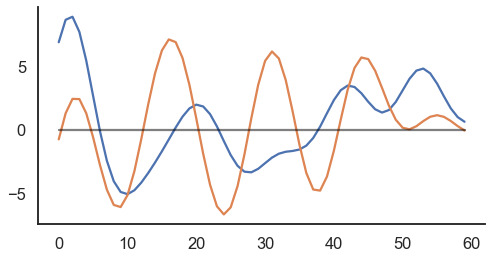

In [8]:
sns.set_theme('talk')
sns.set_style('white')

plt.figure(figsize=(8,4))
sns.lineplot(data =bluestreets_movie_fc_data[2,31,100:160])
sns.lineplot(data=bluestreets_movie_fc_data[2,360,100:160])


zero_line=[]
for x in range(60):
    zero_line.append(0) 

plt.plot(zero_line, color = 'black', alpha = .5)
sns.despine()

## calc fc for a sliding window across events

In [9]:
num_subs = 24

In [10]:
net_label_sep_hc = ['VIS',
 'SOM-MOT',
 'SAL1',
 'DAN1',
 'SAL2',
 'DAN2',
 'LANG',
 'FPN',
 'AUD',
 'ATN',
 'MTN',
 'PMN',
 'MPN',
 'LantHC',
 'LpostHC',
 'RantHC',
 'RpostHC']

In [11]:
net_selection = [10,11,12,13,14,15]

In [13]:
# set up sliding window loop
## 17 TRs is the smallest event length, so we will go through 17 steps and check to see how fc relates to subsequent memory

In [15]:
# from first to last window of an event

In [16]:
window_size = 10
num_windows = 17
num_subs = 24

for window in range(num_windows):
    mov = 0 ## barmaid
    event_list = range(0,14)
    subject = []
    event_recalled = []
    central_d = []
    peri_d = []
    movie = []
    event_length = []
    delay = []
    events=[]
    fc = []
    net1_label=[]
    net2_label = []
    event_label = []

    for sub in range(num_subs):
        temp1 = recall_scoring[recall_scoring['subject']==subject_list[sub]][recall_scoring['movie']==movie_list[mov]]
        for event in range(14):
            event_length_tracker = int(np.round(barmaid_boundaries[0,event+1]))-int(np.round(barmaid_boundaries[0,event]))
            temp2 = temp1[temp1['event']==event+1]
            start = int(np.round(barmaid_boundaries[0,event]))-window_size
            if start<0:
                 start=0
            else:
                start=start
            end = int(np.round(barmaid_boundaries[0,event]))+window_size
            start_window = int(start +np.round((event_length_tracker)/num_windows*window))
            end_window = int(end + np.round((event_length_tracker)/num_windows*window))
            event_fc_data = barmaid_movie_fc_data[sub,:,start_window:end_window]
            event_fc = np.corrcoef(event_fc_data)
            event_fc_z= np.arctanh(event_fc)
            for x in range(np.shape(event_fc_z)[0]):  ## zero out the diagonal
                event_fc_z[x,x]=np.nan
            for net1 in range(6):
                for net2 in range(6):
                    net1_label.append(net_label[net_selection[net1]-1])
                    net2_label.append(net_label[net_selection[net2]-1])
                    net_to_net_fc = event_fc_z[glasser_nodes['community_sublabels']==net_selection[net1]][:,glasser_nodes['community_sublabels']==net_selection[net2]]
                    fc.append(np.nanmean(net_to_net_fc.flatten()))
                    subject.append(subject_list[sub])
                    events.append(event_list[event]+1)
                    event_label.append(event_list[event]+1)
                    delay.append(subjlist_full[subjlist_full['subj_id']==subject_list[sub]][movie_list[mov]+'_delay'].values)
                    movie.append(movie_list[mov])
                    event_length.append(event_length_tracker)
                    event_recalled.append(event_boundaries[event_boundaries['subject']==subject_list[sub]][event_boundaries['movie']==movie_list[mov]][event_boundaries['event']==event+1]['recalled'].values)
                    peri_d.append(temp2['total pd'].values)
                    central_d.append(temp2['total cd'].values)

    mov = 1   # bluestreets movie            
    for sub in range(num_subs):
        temp1 = recall_scoring[recall_scoring['subject']==subject_list[sub]][recall_scoring['movie']==movie_list[mov]]
        for event in range(14):
            event_length_tracker = int(np.round(bluestreets_boundaries[0,event+1]))-int(np.round(bluestreets_boundaries[0,event]))
            temp2 = temp1[temp1['event']==event+1]
            start = int(np.round(bluestreets_boundaries[0,event]))-window_size
            if start<0:
                 start=0
            else:
                start=start
            end = int(np.round(bluestreets_boundaries[0,event]))+window_size
            start_window = int(start +np.round((event_length_tracker)/num_windows*window))
            end_window = int(end + np.round((event_length_tracker)/num_windows*window))
            event_fc_data = bluestreets_movie_fc_data[sub,:,start_window:end_window]
            event_fc = np.corrcoef(event_fc_data)
            event_fc_z= np.arctanh(event_fc)
            for x in range(np.shape(event_fc_z)[0]):  ## zero out the diagonal
                event_fc_z[x,x]=np.nan
            for net1 in range(6):
                for net2 in range(6):
                    net1_label.append(net_label[net_selection[net1]-1])
                    net2_label.append(net_label[net_selection[net2]-1])
                    net_to_net_fc = event_fc_z[glasser_nodes['community_sublabels']==net_selection[net1]][:,glasser_nodes['community_sublabels']==net_selection[net2]]
                    fc.append(np.nanmean(net_to_net_fc.flatten()))
                    subject.append(subject_list[sub])
                    events.append(event_list[event]+1)
                    event_label.append(event_list[event]+1)
                    delay.append(subjlist_full[subjlist_full['subj_id']==subject_list[sub]][movie_list[mov]+'_delay'].values)
                    movie.append(movie_list[mov])
                    event_length.append(int(np.round(bluestreets_boundaries[0,event+1]))-int(np.round(bluestreets_boundaries[0,event])))
                    event_recalled.append(event_boundaries[event_boundaries['subject']==subject_list[sub]][event_boundaries['movie']==movie_list[mov]][event_boundaries['event']==event+1]['recalled'].values)
                    peri_d.append(temp2['total pd'].values)
                    central_d.append(temp2['total cd'].values)

    delay = np.reshape(delay,np.shape(delay)[0])
    event_recalled = np.reshape(event_recalled,np.shape(event_recalled)[0])
    peri_d = np.reshape(peri_d,np.shape(peri_d)[0])
    central_d = np.reshape(central_d,np.shape(central_d)[0])

    data3= np.transpose([subject,movie,events,delay,fc,net1_label,net2_label,event_label,event_length,event_recalled,peri_d,central_d])
    columns3 = ['subject','movie','events','delay','fc','net1_label','net2_label','event_label','event_length','event_recalled','peri_d','central_d']

    sliding_window_encoding_fc_recall_pd = pd.DataFrame(data =data3, columns = columns3)


    sliding_window_encoding_fc_recall_pd['fc'] = sliding_window_encoding_fc_recall_pd['fc'].astype('float')
    sliding_window_encoding_fc_recall_pd['event_length'] = sliding_window_encoding_fc_recall_pd['event_length'].astype('float')
    sliding_window_encoding_fc_recall_pd['peri_d'] = sliding_window_encoding_fc_recall_pd['peri_d'].astype('float')
    sliding_window_encoding_fc_recall_pd['central_d'] = sliding_window_encoding_fc_recall_pd['central_d'].astype('float')
    sliding_window_encoding_fc_recall_pd['event_recalled'] = sliding_window_encoding_fc_recall_pd['event_recalled'].astype('float')
    sliding_window_encoding_fc_recall_pd['delay'] = sliding_window_encoding_fc_recall_pd['delay'].astype('str')

    sliding_window_encoding_fc_recall_pd.to_csv(analysis_dir+'sliding_window_encoding_fc_recall_pd_'+str(window)+'.csv')

In [ ]:
# add in the next 10 windows into the subsequent event to see where the effect goes

In [17]:
window_size = 10
num_windows = 17
num_subs = 24

for window in range(18,27):
    mov = 0 ## barmaid
    event_list = range(0,14)
    subject = []
    event_recalled = []
    central_d = []
    peri_d = []
    movie = []
    event_length = []
    delay = []
    events=[]
    fc = []
    net1_label=[]
    net2_label = []
    event_label = []

    for sub in range(num_subs):
        temp1 = recall_scoring[recall_scoring['subject']==subject_list[sub]][recall_scoring['movie']==movie_list[mov]]
        for event in range(14):
            event_length_tracker = int(np.round(barmaid_boundaries[0,event+1]))-int(np.round(barmaid_boundaries[0,event]))
            temp2 = temp1[temp1['event']==event+1]
            start = int(np.round(barmaid_boundaries[0,event]))-window_size
            if start<0:
                 start=0
            else:
                start=start
            end = int(np.round(barmaid_boundaries[0,event]))+window_size
            start_window = int(start +np.round((event_length_tracker)/num_windows*window))
            end_window = int(end + np.round((event_length_tracker)/num_windows*window))
            event_fc_data = barmaid_movie_fc_data[sub,:,start_window:end_window]
            event_fc = np.corrcoef(event_fc_data)
            event_fc_z= np.arctanh(event_fc)
            for x in range(np.shape(event_fc_z)[0]):  ## zero out the diagonal
                event_fc_z[x,x]=np.nan
            for net1 in range(6):
                for net2 in range(6):
                    net1_label.append(net_label[net_selection[net1]-1])
                    net2_label.append(net_label[net_selection[net2]-1])
                    net_to_net_fc = event_fc_z[glasser_nodes['community_sublabels']==net_selection[net1]][:,glasser_nodes['community_sublabels']==net_selection[net2]]
                    fc.append(np.nanmean(net_to_net_fc.flatten()))
                    subject.append(subject_list[sub])
                    events.append(event_list[event]+1)
                    event_label.append(event_list[event]+1)
                    delay.append(subjlist_full[subjlist_full['subj_id']==subject_list[sub]][movie_list[mov]+'_delay'].values)
                    movie.append(movie_list[mov])
                    event_length.append(event_length_tracker)
                    event_recalled.append(event_boundaries[event_boundaries['subject']==subject_list[sub]][event_boundaries['movie']==movie_list[mov]][event_boundaries['event']==event+1]['recalled'].values)
                    peri_d.append(temp2['total pd'].values)
                    central_d.append(temp2['total cd'].values)

    mov = 1   # bluestreets movie            
    for sub in range(num_subs):
        temp1 = recall_scoring[recall_scoring['subject']==subject_list[sub]][recall_scoring['movie']==movie_list[mov]]
        for event in range(14):
            event_length_tracker = int(np.round(bluestreets_boundaries[0,event+1]))-int(np.round(bluestreets_boundaries[0,event]))
            temp2 = temp1[temp1['event']==event+1]
            start = int(np.round(bluestreets_boundaries[0,event]))-window_size
            if start<0:
                 start=0
            else:
                start=start
            end = int(np.round(bluestreets_boundaries[0,event]))+window_size
            start_window = int(start +np.round((event_length_tracker)/num_windows*window))
            end_window = int(end + np.round((event_length_tracker)/num_windows*window))
            event_fc_data = bluestreets_movie_fc_data[sub,:,start_window:end_window]
            event_fc = np.corrcoef(event_fc_data)
            event_fc_z= np.arctanh(event_fc)
            for x in range(np.shape(event_fc_z)[0]):  ## zero out the diagonal
                event_fc_z[x,x]=np.nan
            for net1 in range(6):
                for net2 in range(6):
                    net1_label.append(net_label[net_selection[net1]-1])
                    net2_label.append(net_label[net_selection[net2]-1])
                    net_to_net_fc = event_fc_z[glasser_nodes['community_sublabels']==net_selection[net1]][:,glasser_nodes['community_sublabels']==net_selection[net2]]
                    fc.append(np.nanmean(net_to_net_fc.flatten()))
                    subject.append(subject_list[sub])
                    events.append(event_list[event]+1)
                    event_label.append(event_list[event]+1)
                    delay.append(subjlist_full[subjlist_full['subj_id']==subject_list[sub]][movie_list[mov]+'_delay'].values)
                    movie.append(movie_list[mov])
                    event_length.append(int(np.round(bluestreets_boundaries[0,event+1]))-int(np.round(bluestreets_boundaries[0,event])))
                    event_recalled.append(event_boundaries[event_boundaries['subject']==subject_list[sub]][event_boundaries['movie']==movie_list[mov]][event_boundaries['event']==event+1]['recalled'].values)
                    peri_d.append(temp2['total pd'].values)
                    central_d.append(temp2['total cd'].values)

    delay = np.reshape(delay,np.shape(delay)[0])
    event_recalled = np.reshape(event_recalled,np.shape(event_recalled)[0])
    peri_d = np.reshape(peri_d,np.shape(peri_d)[0])
    central_d = np.reshape(central_d,np.shape(central_d)[0])

    data3= np.transpose([subject,movie,events,delay,fc,net1_label,net2_label,event_label,event_length,event_recalled,peri_d,central_d])
    columns3 = ['subject','movie','events','delay','fc','net1_label','net2_label','event_label','event_length','event_recalled','peri_d','central_d']

    sliding_window_encoding_fc_recall_pd = pd.DataFrame(data =data3, columns = columns3)


    sliding_window_encoding_fc_recall_pd['fc'] = sliding_window_encoding_fc_recall_pd['fc'].astype('float')
    sliding_window_encoding_fc_recall_pd['event_length'] = sliding_window_encoding_fc_recall_pd['event_length'].astype('float')
    sliding_window_encoding_fc_recall_pd['peri_d'] = sliding_window_encoding_fc_recall_pd['peri_d'].astype('float')
    sliding_window_encoding_fc_recall_pd['central_d'] = sliding_window_encoding_fc_recall_pd['central_d'].astype('float')
    sliding_window_encoding_fc_recall_pd['event_recalled'] = sliding_window_encoding_fc_recall_pd['event_recalled'].astype('float')
    sliding_window_encoding_fc_recall_pd['delay'] = sliding_window_encoding_fc_recall_pd['delay'].astype('str')

    sliding_window_encoding_fc_recall_pd.to_csv(analysis_dir+'sliding_window_encoding_fc_recall_pd_'+str(window)+'.csv')

In [ ]:
# delete the below section?

In [22]:
window_size = 10
num_windows = 17
num_subs = 24

window=17
mov = 0 ## barmaid
event_list = range(0,14)
subject = []
event_recalled = []
central_d = []
peri_d = []
movie = []
event_length = []
delay = []
events=[]
fc = []
net1_label=[]
net2_label = []
event_label = []

for sub in range(num_subs):
    temp1 = recall_scoring[recall_scoring['subject']==subject_list[sub]][recall_scoring['movie']==movie_list[mov]]
    for event in range(14):
        event_length_tracker = int(np.round(barmaid_boundaries[0,event+1]))-int(np.round(barmaid_boundaries[0,event]))
        temp2 = temp1[temp1['event']==event+1]
        start = int(np.round(barmaid_boundaries[0,event]))-window_size
        if start<0:
             start=0
        else:
            start=start
        end = int(np.round(barmaid_boundaries[0,event]))+window_size
        start_window = int(start +np.round((event_length_tracker)/num_windows*window))
        end_window = int(end + np.round((event_length_tracker)/num_windows*window))
        event_fc_data = barmaid_movie_fc_data[sub,:,start_window:end_window]
        event_fc = np.corrcoef(event_fc_data)
        event_fc_z= np.arctanh(event_fc)
        for x in range(np.shape(event_fc_z)[0]):  ## zero out the diagonal
            event_fc_z[x,x]=np.nan
        for net1 in range(6):
            for net2 in range(6):
                net1_label.append(net_label[net_selection[net1]-1])
                net2_label.append(net_label[net_selection[net2]-1])
                net_to_net_fc = event_fc_z[glasser_nodes['community_sublabels']==net_selection[net1]][:,glasser_nodes['community_sublabels']==net_selection[net2]]
                fc.append(np.nanmean(net_to_net_fc.flatten()))
                subject.append(subject_list[sub])
                events.append(event_list[event]+1)
                event_label.append(event_list[event]+1)
                delay.append(subjlist_full[subjlist_full['subj_id']==subject_list[sub]][movie_list[mov]+'_delay'].values)
                movie.append(movie_list[mov])
                event_length.append(event_length_tracker)
                event_recalled.append(event_boundaries[event_boundaries['subject']==subject_list[sub]][event_boundaries['movie']==movie_list[mov]][event_boundaries['event']==event+1]['recalled'].values)
                peri_d.append(temp2['total pd'].values)
                central_d.append(temp2['total cd'].values)

mov = 1   # bluestreets movie            
for sub in range(num_subs):
    temp1 = recall_scoring[recall_scoring['subject']==subject_list[sub]][recall_scoring['movie']==movie_list[mov]]
    for event in range(14):
        event_length_tracker = int(np.round(bluestreets_boundaries[0,event+1]))-int(np.round(bluestreets_boundaries[0,event]))
        temp2 = temp1[temp1['event']==event+1]
        start = int(np.round(bluestreets_boundaries[0,event]))-window_size
        if start<0:
             start=0
        else:
            start=start
        end = int(np.round(bluestreets_boundaries[0,event]))+window_size
        start_window = int(start +np.round((event_length_tracker)/num_windows*window))
        end_window = int(end + np.round((event_length_tracker)/num_windows*window))
        event_fc_data = bluestreets_movie_fc_data[sub,:,start_window:end_window]
        event_fc = np.corrcoef(event_fc_data)
        event_fc_z= np.arctanh(event_fc)
        for x in range(np.shape(event_fc_z)[0]):  ## zero out the diagonal
            event_fc_z[x,x]=np.nan
        for net1 in range(6):
            for net2 in range(6):
                net1_label.append(net_label[net_selection[net1]-1])
                net2_label.append(net_label[net_selection[net2]-1])
                net_to_net_fc = event_fc_z[glasser_nodes['community_sublabels']==net_selection[net1]][:,glasser_nodes['community_sublabels']==net_selection[net2]]
                fc.append(np.nanmean(net_to_net_fc.flatten()))
                subject.append(subject_list[sub])
                events.append(event_list[event]+1)
                event_label.append(event_list[event]+1)
                delay.append(subjlist_full[subjlist_full['subj_id']==subject_list[sub]][movie_list[mov]+'_delay'].values)
                movie.append(movie_list[mov])
                event_length.append(int(np.round(bluestreets_boundaries[0,event+1]))-int(np.round(bluestreets_boundaries[0,event])))
                event_recalled.append(event_boundaries[event_boundaries['subject']==subject_list[sub]][event_boundaries['movie']==movie_list[mov]][event_boundaries['event']==event+1]['recalled'].values)
                peri_d.append(temp2['total pd'].values)
                central_d.append(temp2['total cd'].values)

delay = np.reshape(delay,np.shape(delay)[0])
event_recalled = np.reshape(event_recalled,np.shape(event_recalled)[0])
peri_d = np.reshape(peri_d,np.shape(peri_d)[0])
central_d = np.reshape(central_d,np.shape(central_d)[0])

data3= np.transpose([subject,movie,events,delay,fc,net1_label,net2_label,event_label,event_length,event_recalled,peri_d,central_d])
columns3 = ['subject','movie','events','delay','fc','net1_label','net2_label','event_label','event_length','event_recalled','peri_d','central_d']

sliding_window_encoding_fc_recall_pd = pd.DataFrame(data =data3, columns = columns3)


sliding_window_encoding_fc_recall_pd['fc'] = sliding_window_encoding_fc_recall_pd['fc'].astype('float')
sliding_window_encoding_fc_recall_pd['event_length'] = sliding_window_encoding_fc_recall_pd['event_length'].astype('float')
sliding_window_encoding_fc_recall_pd['peri_d'] = sliding_window_encoding_fc_recall_pd['peri_d'].astype('float')
sliding_window_encoding_fc_recall_pd['central_d'] = sliding_window_encoding_fc_recall_pd['central_d'].astype('float')
sliding_window_encoding_fc_recall_pd['event_recalled'] = sliding_window_encoding_fc_recall_pd['event_recalled'].astype('float')
sliding_window_encoding_fc_recall_pd['delay'] = sliding_window_encoding_fc_recall_pd['delay'].astype('str')

sliding_window_encoding_fc_recall_pd.to_csv(analysis_dir+'sliding_window_encoding_fc_recall_pd_'+str(window)+'.csv')

In [12]:
DMN_nets = ['PMN']

In [13]:
fc_estimate_all = []
stdev_estimate_all = []

for net in range(np.size(DMN_nets)):
    
    fc_estimate = []
    stdev_estimate = []
    for window in range(27):


        sliding_window_encoding_fc_recall = pd.read_csv(analysis_dir+'sliding_window_encoding_fc_recall_pd_'+str(window)+'.csv')
        model_data1 =sliding_window_encoding_fc_recall[sliding_window_encoding_fc_recall['net1_label']=='antHC'][sliding_window_encoding_fc_recall['net2_label']==DMN_nets[net]]
        model_data2 = sliding_window_encoding_fc_recall[sliding_window_encoding_fc_recall['net1_label']=='postHC'][sliding_window_encoding_fc_recall['net2_label']==DMN_nets[net]]

        model_data3 = pd.concat([model_data1, model_data2])
        model_data_sub_mean =model_data3.groupby('subject').mean()

        fc_mc = []
        for i in range(np.shape(model_data3)[0]):
            fc_mc.append(model_data3.iloc[i]['fc'] - model_data_sub_mean.loc[model_data3.iloc[i]['subject']]['fc'])


        model_data3['fc_mc'] =fc_mc
        model_data3['event_recalled'] = model_data3['event_recalled'].astype('category')

        model_data3['boundary_diff_hc'] =boundary_diff_hc
        model_data3['boundary_diff_pmn'] =np.concatenate([boundary_diff_pmn,boundary_diff_pmn])
        model_data3['boundary_diff_mtn'] =np.concatenate([boundary_diff_mtn,boundary_diff_mtn])
        model_data3['boundary_diff_mpn'] =np.concatenate([boundary_diff_mpn,boundary_diff_mpn])
        model_data3['boundary_diff_atn'] =np.concatenate([boundary_diff_atn,boundary_diff_atn])

        model = smf.mixedlm('fc~event_recalled', model_data3,
                            groups = 'subject', missing='drop')
        mdf = model.fit(method = 'lbfgs')

        fc_estimate.append(mdf.params[1])
        stdev_estimate.append(mdf.bse[1])
    fc_estimate_all.append(fc_estimate)

    stdev_estimate_all.append(stdev_estimate)

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning

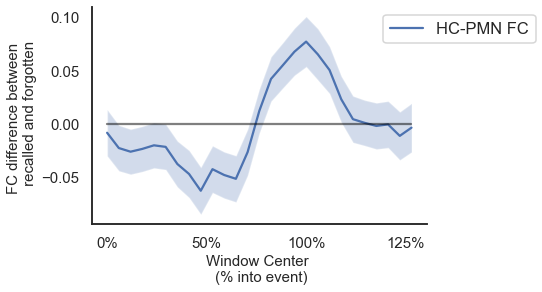

In [14]:

sns.set_style('white')

plt.plot(np.transpose(fc_estimate_all[0]))

zero_line=[]
for x in range(27):
    zero_line.append(0) 
    
plt.plot(zero_line, color = 'black', alpha = .5)

plt.xlabel('Window Center \n (% into event)',fontsize=15)
plt.ylabel('FC difference between \n recalled and forgotten',fontsize=15)
plt.legend(['HC-PMN FC'], bbox_to_anchor=(.85,.5, .5, .5))

plt.tick_params(axis='both', which='major', labelsize=15)

x_value=[]
for x in range(27):
    x_value.append(x) 

 
plt.fill_between(x_value, np.array(fc_estimate_all[0])-stdev_estimate_all[0], np.array(fc_estimate_all[0])+stdev_estimate_all[0],alpha=0.25)


locs, labels = plt.xticks()
plt.xticks([0, 8.5, 17,25.5], ['0%', '50%', '100%', '125%'])


sns.despine()

#plt.savefig(analysis_dir+'hc-net-fc-sliding-window-recall.tiff', format='tiff',dpi=300,bbox_inches = 'tight')

In [15]:
net = 0   
fc_estimate = []
bse_estimate = []
pv= []
z_scores = []
for window in range(27):


    sliding_window_encoding_fc_recall = pd.read_csv(analysis_dir+'sliding_window_encoding_fc_recall_pd_'+str(window)+'.csv')
    model_data1 =sliding_window_encoding_fc_recall[sliding_window_encoding_fc_recall['net1_label']=='antHC'][sliding_window_encoding_fc_recall['net2_label']==DMN_nets[net]]
    model_data2 = sliding_window_encoding_fc_recall[sliding_window_encoding_fc_recall['net1_label']=='postHC'][sliding_window_encoding_fc_recall['net2_label']==DMN_nets[net]]

    model_data3 = pd.concat([model_data1, model_data2])
    model_data_sub_mean =model_data3.groupby('subject').mean()

    fc_mc = []
    for i in range(np.shape(model_data3)[0]):
        fc_mc.append(model_data3.iloc[i]['fc'] - model_data_sub_mean.loc[model_data3.iloc[i]['subject']]['fc'])


    model_data3['fc_mc'] =fc_mc
    model_data3['event_recalled'] = model_data3['event_recalled'].astype('category')
    model_data3 = model_data3
    

    model = smf.mixedlm('fc~event_recalled', model_data3,
                        groups = 'subject', missing='drop')
    mdf = model.fit(method = 'lbfgs')

    fc_estimate.append(mdf.params[1])
    bse_estimate.append(mdf.bse[1])
    pv.append(mdf.pvalues[1])
    z_scores.append(mdf.tvalues[1])


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning

In [17]:
# convert to one-sided values
pv = np.array(pv)/2
pv

array([0.35281635, 0.14581201, 0.10960206, 0.13493557, 0.17307003,
       0.15677369, 0.04076835, 0.01709858, 0.0022368 , 0.02677498,
       0.01376677, 0.00903199, 0.11110373, 0.27647819, 0.02133241,
       0.00489494, 0.00108949, 0.00050943, 0.00331209, 0.01087391,
       0.14142082, 0.4176185 , 0.47962862, 0.46666401, 0.49312194,
       0.31105276, 0.44000788])

In [19]:
np.where(np.array(pv)<.05)

(array([ 6,  7,  8,  9, 10, 11, 14, 15, 16, 17, 18, 19]),)

In [20]:
pv[4:11]

array([0.17307003, 0.15677369, 0.04076835, 0.01709858, 0.0022368 ,
       0.02677498, 0.01376677])

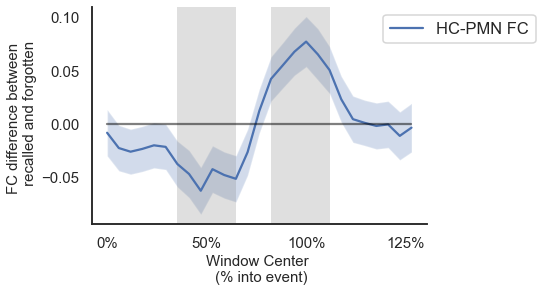

In [21]:

sns.set_style('white')
#sns.set_theme('notebook')
fig, ax = plt.subplots()
plt.plot(np.transpose(fc_estimate))

zero_line=[]
for x in range(27):
    zero_line.append(0) 
    
plt.plot(zero_line, color = 'black', alpha = .5)

plt.xlabel('Window Center \n (% into event)',fontsize=15)
plt.ylabel('FC difference between \n recalled and forgotten',fontsize=15)
plt.legend(['HC-PMN FC'], bbox_to_anchor=(.85,.5, .5, .5))
plt.tick_params(axis='both', which='major', labelsize=15)

x_value=[]
for x in range(27):
    x_value.append(x) 


plt.fill_between(x_value, np.array(fc_estimate)-bse_estimate, np.array(fc_estimate)+bse_estimate,alpha=0.25)
ax.axvspan(14, 19, alpha=0.25, color='gray',linewidth = 0)
ax.axvspan(6, 11, alpha=0.25, color='gray',linewidth = 0)

locs, labels = plt.xticks()
plt.xticks([0, 8.5, 17,25.5], ['0%', '50%', '100%', '125%'])


sns.despine()

#plt.savefig(analysis_dir+'hc-net-fc-sliding-window-recall-shaded.tiff', format='tiff',dpi=300,bbox_inches = 'tight')

In [26]:
model_data3 = model_data3.reset_index()
index_test = np.array(model_data3.index)

In [27]:
event_recalled = model_data3['event_recalled'].values

In [28]:
import warnings
warnings.filterwarnings('ignore')

In [29]:
import random


### permutation test to find max cluster size of consecutive timepoints significant timepoint


In [30]:
net = 0   

max_cluster_perm = []
for perm in range(1000):
    random.shuffle(index_test)
    pv= []
    for window in range(27):


        sliding_window_encoding_fc_recall = pd.read_csv(analysis_dir+'sliding_window_encoding_fc_recall_pd_'+str(window)+'.csv')
        model_data1 =sliding_window_encoding_fc_recall[sliding_window_encoding_fc_recall['net1_label']=='antHC'][sliding_window_encoding_fc_recall['net2_label']==DMN_nets[net]]
        model_data2 = sliding_window_encoding_fc_recall[sliding_window_encoding_fc_recall['net1_label']=='postHC'][sliding_window_encoding_fc_recall['net2_label']==DMN_nets[net]]

        model_data3 = pd.concat([model_data1, model_data2])
        model_data_sub_mean =model_data3.groupby('subject').mean()

        fc_mc = []
        for i in range(np.shape(model_data3)[0]):
            fc_mc.append(model_data3.iloc[i]['fc'] - model_data_sub_mean.loc[model_data3.iloc[i]['subject']]['fc'])


        model_data3['fc_mc'] =fc_mc
        model_data3['event_recalled'] = model_data3['event_recalled'].astype('category')

        model_data3['boundary_diff_hc'] =boundary_diff_hc
        model_data3['boundary_diff_pmn'] =np.concatenate([boundary_diff_pmn,boundary_diff_pmn])
        model_data3['boundary_diff_mtn'] =np.concatenate([boundary_diff_mtn,boundary_diff_mtn])
        model_data3['boundary_diff_mpn'] =np.concatenate([boundary_diff_mpn,boundary_diff_mpn])
        model_data3['boundary_diff_atn'] =np.concatenate([boundary_diff_atn,boundary_diff_atn])
        model_data3['event_recalled'] = event_recalled[index_test]
        model = smf.mixedlm('fc~event_recalled', model_data3,
                            groups = 'subject', missing='drop')
        mdf = model.fit(method = 'lbfgs')

        pv.append(mdf.pvalues[1])
        
    sig_spots = np.where(np.array(pv)<.1)
    sig_spots = sig_spots[0]
    current_cluster = 1
    max_cluster = 1
    for i in range(np.size(sig_spots)-1):
        if sig_spots[i]-sig_spots[i+1] == -1:
            current_cluster =current_cluster+1
            if current_cluster>max_cluster:
                max_cluster = current_cluster
        if sig_spots[i]-sig_spots[i+1] != -1:
            current_cluster =1
    max_cluster_perm.append(max_cluster)

In [31]:
np.size(np.where(np.array(max_cluster_perm)>3))/1000

0.0

In [105]:
max_cluster_perm_1 = max_cluster_perm

In [122]:
max_cluster_perm_1

[1,
 3,
 1,
 1,
 1,
 1,
 1,
 3,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 3,
 1,
 3,
 1,
 1,
 1,
 1,
 2,
 2,
 1,
 2,
 1,
 2,
 3,
 2,
 1,
 3,
 3,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 3,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 3,
 1,
 1,
 1,
 1,
 1,
 4,
 1,
 1,
 1,
 2,
 2,
 1,
 4,
 1,
 2,
 1,
 2,
 3,
 3,
 1,
 1]

(array([770.,  70.,  35.,  15.,   5.,   6.,   1.,   0.,   1.,   1.]),
 array([ 1. ,  2.1,  3.2,  4.3,  5.4,  6.5,  7.6,  8.7,  9.8, 10.9, 12. ]),
 <BarContainer object of 10 artists>)

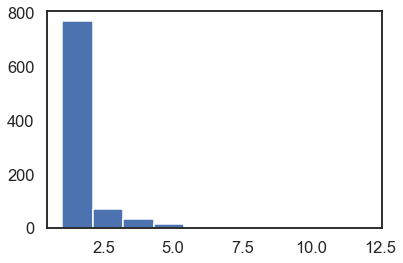

In [107]:
plt.hist(max_cluster_perm)

In [83]:
model_data3 = model_data3.reset_index()

In [88]:
np.array(model_data3.index)

array([   0,    1,    2, ..., 1341, 1342, 1343])

In [39]:
event_recalled = model_data3['event_recalled'].values

In [41]:
event_recalled = np.array(event_recalled)

In [43]:
random.shuffle(event_recalled)

In [44]:
event_recalled

array([1., 1., 1., ..., 1., 0., 1.])